In [10]:
%load_ext autoreload
%autoreload 2

import numpy  as np
import pandas as pd
import h5py

from tqdm       import tqdm
from astropy    import units
from matplotlib import pyplot as plt

from scipy.interpolate import interp1d, RegularGridInterpolator

from common import hallmark as hm
from common import mockservation as mk
from common import dalt
from common import viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def getdist(path, dist):
    df = pd.read_csv(path, sep='\t')
    return df[dist].values

pf = hm.ParaFrame('cache/Illinois_thermal_w{win:d}/{mag}a{aspin:g}_i{inc:d}/gt_Rh{Rhigh:d}_{freq}.h5')

for k in set(pf.keys()) - {'path'}:
    globals()[k] = np.unique(pf[k])
    print(k, globals()[k][:16])

win [3 4 5]
inc [ 10  30  50  70  90 110 130 150 170]
freq ['230GHz' '2um' '86GHz']
Rhigh [  1  10  40 160]
aspin [-0.94 -0.5   0.    0.5   0.94]
mag ['M' 'S']


In [12]:
AALM = pd.read_csv('data/AALM.tsv', sep='\t')
AZLM = pd.read_csv('data/AZLM.tsv', sep='\t')

AALM, AZLM = AALM[AALM.time.isin(AZLM.time)], AZLM[AZLM.time.isin(AALM.time)]

zbl = pd.DataFrame()
zbl['t'] = AZLM.time - AZLM.time.iloc[0]
zbl['v'] = 0
zbl['u'] = 0

azlm = pd.DataFrame()
azlm['t'] =  AZLM.time - AZLM.time.iloc[0]
azlm['v'] =  AZLM.v
azlm['u'] =  AZLM.u
azlm_uvd2 = (azlm.v * azlm.v + azlm.u * azlm.u).values

aalm = pd.DataFrame()
aalm['t'] =  AALM.time - AALM.time.iloc[0]
aalm['v'] = -AALM.v
aalm['u'] = -AALM.u
aalm_uvd2 = (aalm.v * aalm.v + aalm.u * aalm.u).values

time = zbl.t.values

In [13]:
def compare(file):
    
    df    = pd.read_csv(file.replace('gt_', 'summ_').replace('.h5', '.tsv'), sep='\t')
    major = interp1d(df.time_hr - df.time_hr.iloc[0], df.major_FWHM)
    minor = interp1d(df.time_hr - df.time_hr.iloc[0], df.minor_FWHM)
    
    with h5py.File(file) as h:
        m    = h['meta']
        meta = dalt.ImageMeta(**{k:m[k][()] for k in m.keys()})
        data = h['data'][:]
    
    mov = dalt.Image(data, meta=meta)
    vis = mk.mockserve(mov, N=256)
    
    U, V = vis.uvd

    u = np.linspace( 0,   U/2, num=vis.shape[-1])
    v = np.linspace(-V/2, V/2, num=vis.shape[-2], endpoint=False)
    t = (vis.meta.time - vis.meta.time[0]).value
    
    amp = RegularGridInterpolator((t, v, u[::-1]), abs(vis[...,::-1]))

    maxsz = np.sqrt(4 * np.log(2) *
        np.log(amp(zbl) / amp(azlm)) / (np.pi * np.pi * azlm_uvd2)
    ) / units.uas.to(units.rad)
    
    minsz = np.sqrt(4 * np.log(2) *
        np.log(amp(azlm) / amp(aalm)) / (np.pi * np.pi * (aalm_uvd2 - azlm_uvd2))
    ) / units.uas.to(units.rad)

    #plt.plot(time, major(time))
    #plt.plot(time, minor(time))
    #plt.plot(time, maxsz)
    #plt.plot(time, minsz)
    
    return major(time), minor(time), maxsz, minsz

100it [02:20,  1.41s/it]


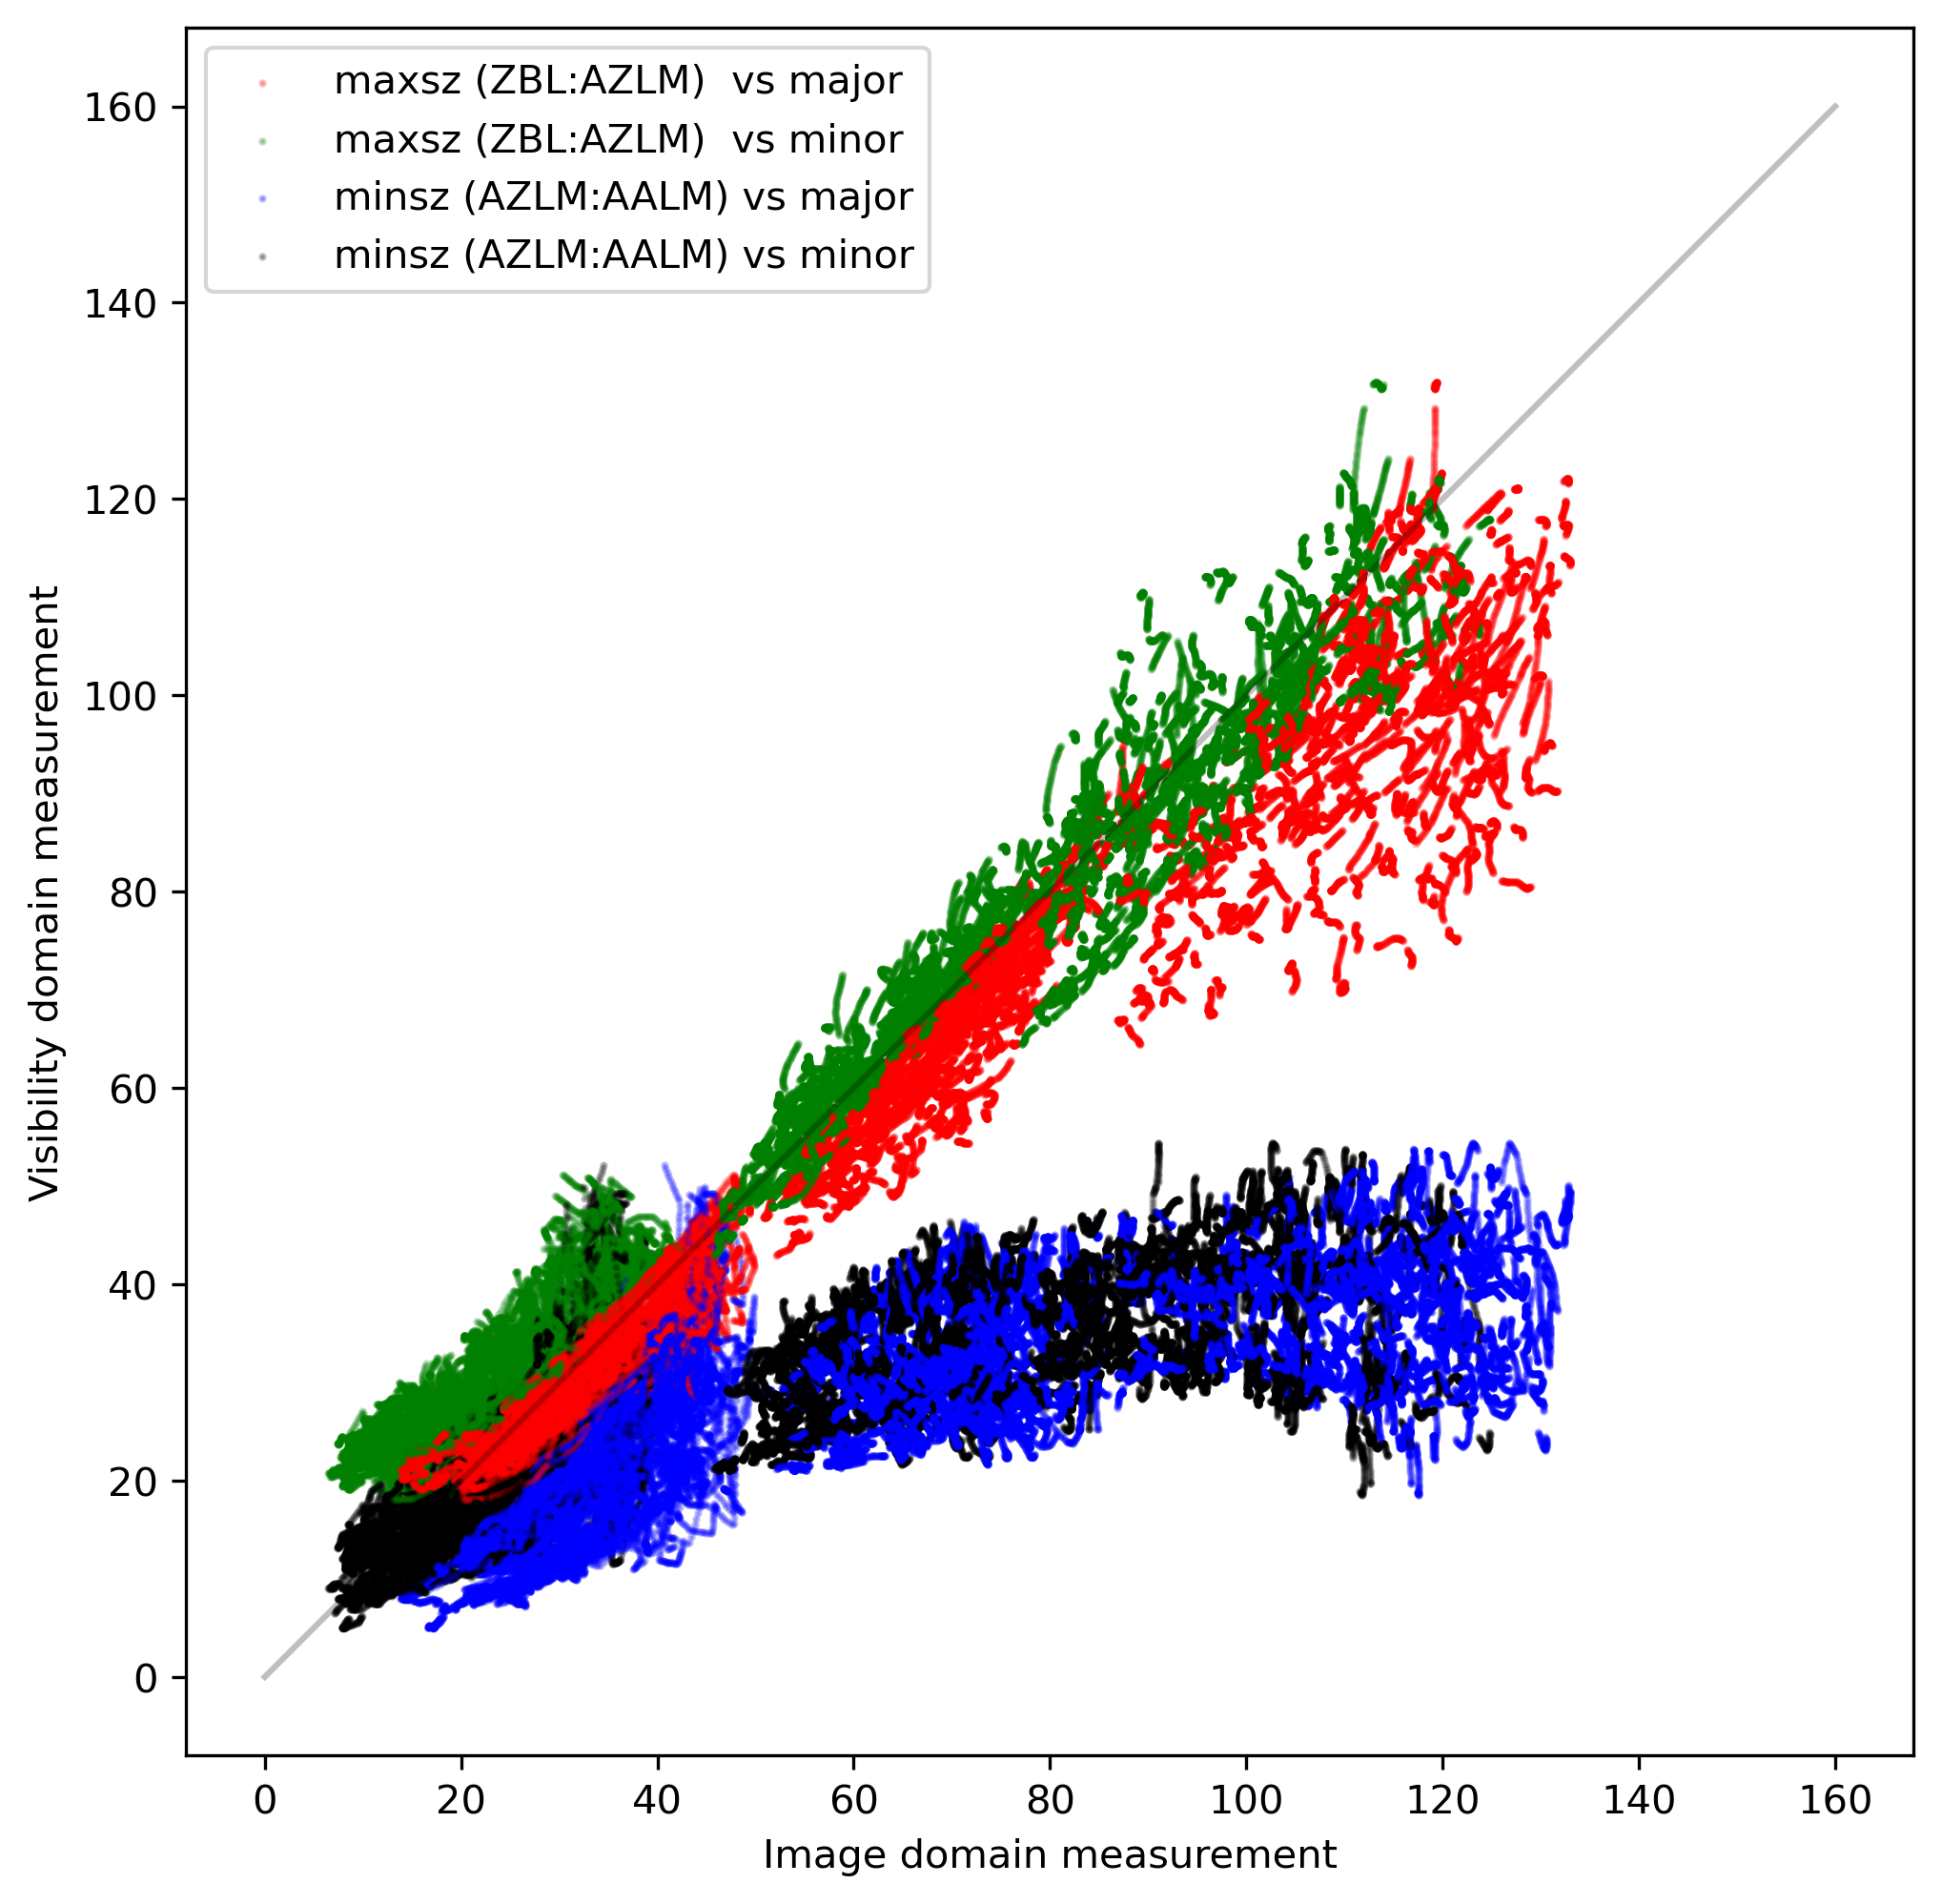

In [31]:
plt.figure(figsize=(8, 8), dpi=300)

for i, p in tqdm(enumerate(pf.path[:100])):
    major, minor, maxsz, minsz = compare(p)
    
    if i == 0:
        plt.scatter(major, maxsz, s=1, color='r', alpha=1/4, label='maxsz (ZBL:AZLM)  vs major')
        plt.scatter(minor, maxsz, s=1, color='g', alpha=1/4, label='maxsz (ZBL:AZLM)  vs minor')
        plt.scatter(major, minsz, s=1, color='b', alpha=1/4, label='minsz (AZLM:AALM) vs major')
        plt.scatter(minor, minsz, s=1, color='k', alpha=1/4, label='minsz (AZLM:AALM) vs minor')
    else:
        plt.scatter(major, maxsz, s=1, color='r', alpha=1/4)
        plt.scatter(minor, maxsz, s=1, color='g', alpha=1/4)
        plt.scatter(major, minsz, s=1, color='b', alpha=1/4)
        plt.scatter(minor, minsz, s=1, color='k', alpha=1/4)

plt.plot([0,160], [0,160], color='k', alpha=1/4)
plt.legend(loc='upper left')

plt.gca().set_aspect('equal')
plt.xlabel('Image domain measurement')
plt.ylabel('Visibility domain measurement')

plt.savefig('output/plot/vis_vs_img.png')

110it [02:33,  1.40s/it]/var/folders/_r/n2nr49210r7grg51tz86fqs000019j/T/ipykernel_16778/3581398646.py:23: RuntimeWarning: invalid value encountered in sqrt
  minsz = np.sqrt(4 * np.log(2) *
121it [02:49,  1.39s/it]/var/folders/_r/n2nr49210r7grg51tz86fqs000019j/T/ipykernel_16778/3581398646.py:27: RuntimeWarning: invalid value encountered in sqrt
  maxsz = np.sqrt(4 * np.log(2) *
1000it [24:35,  1.48s/it]


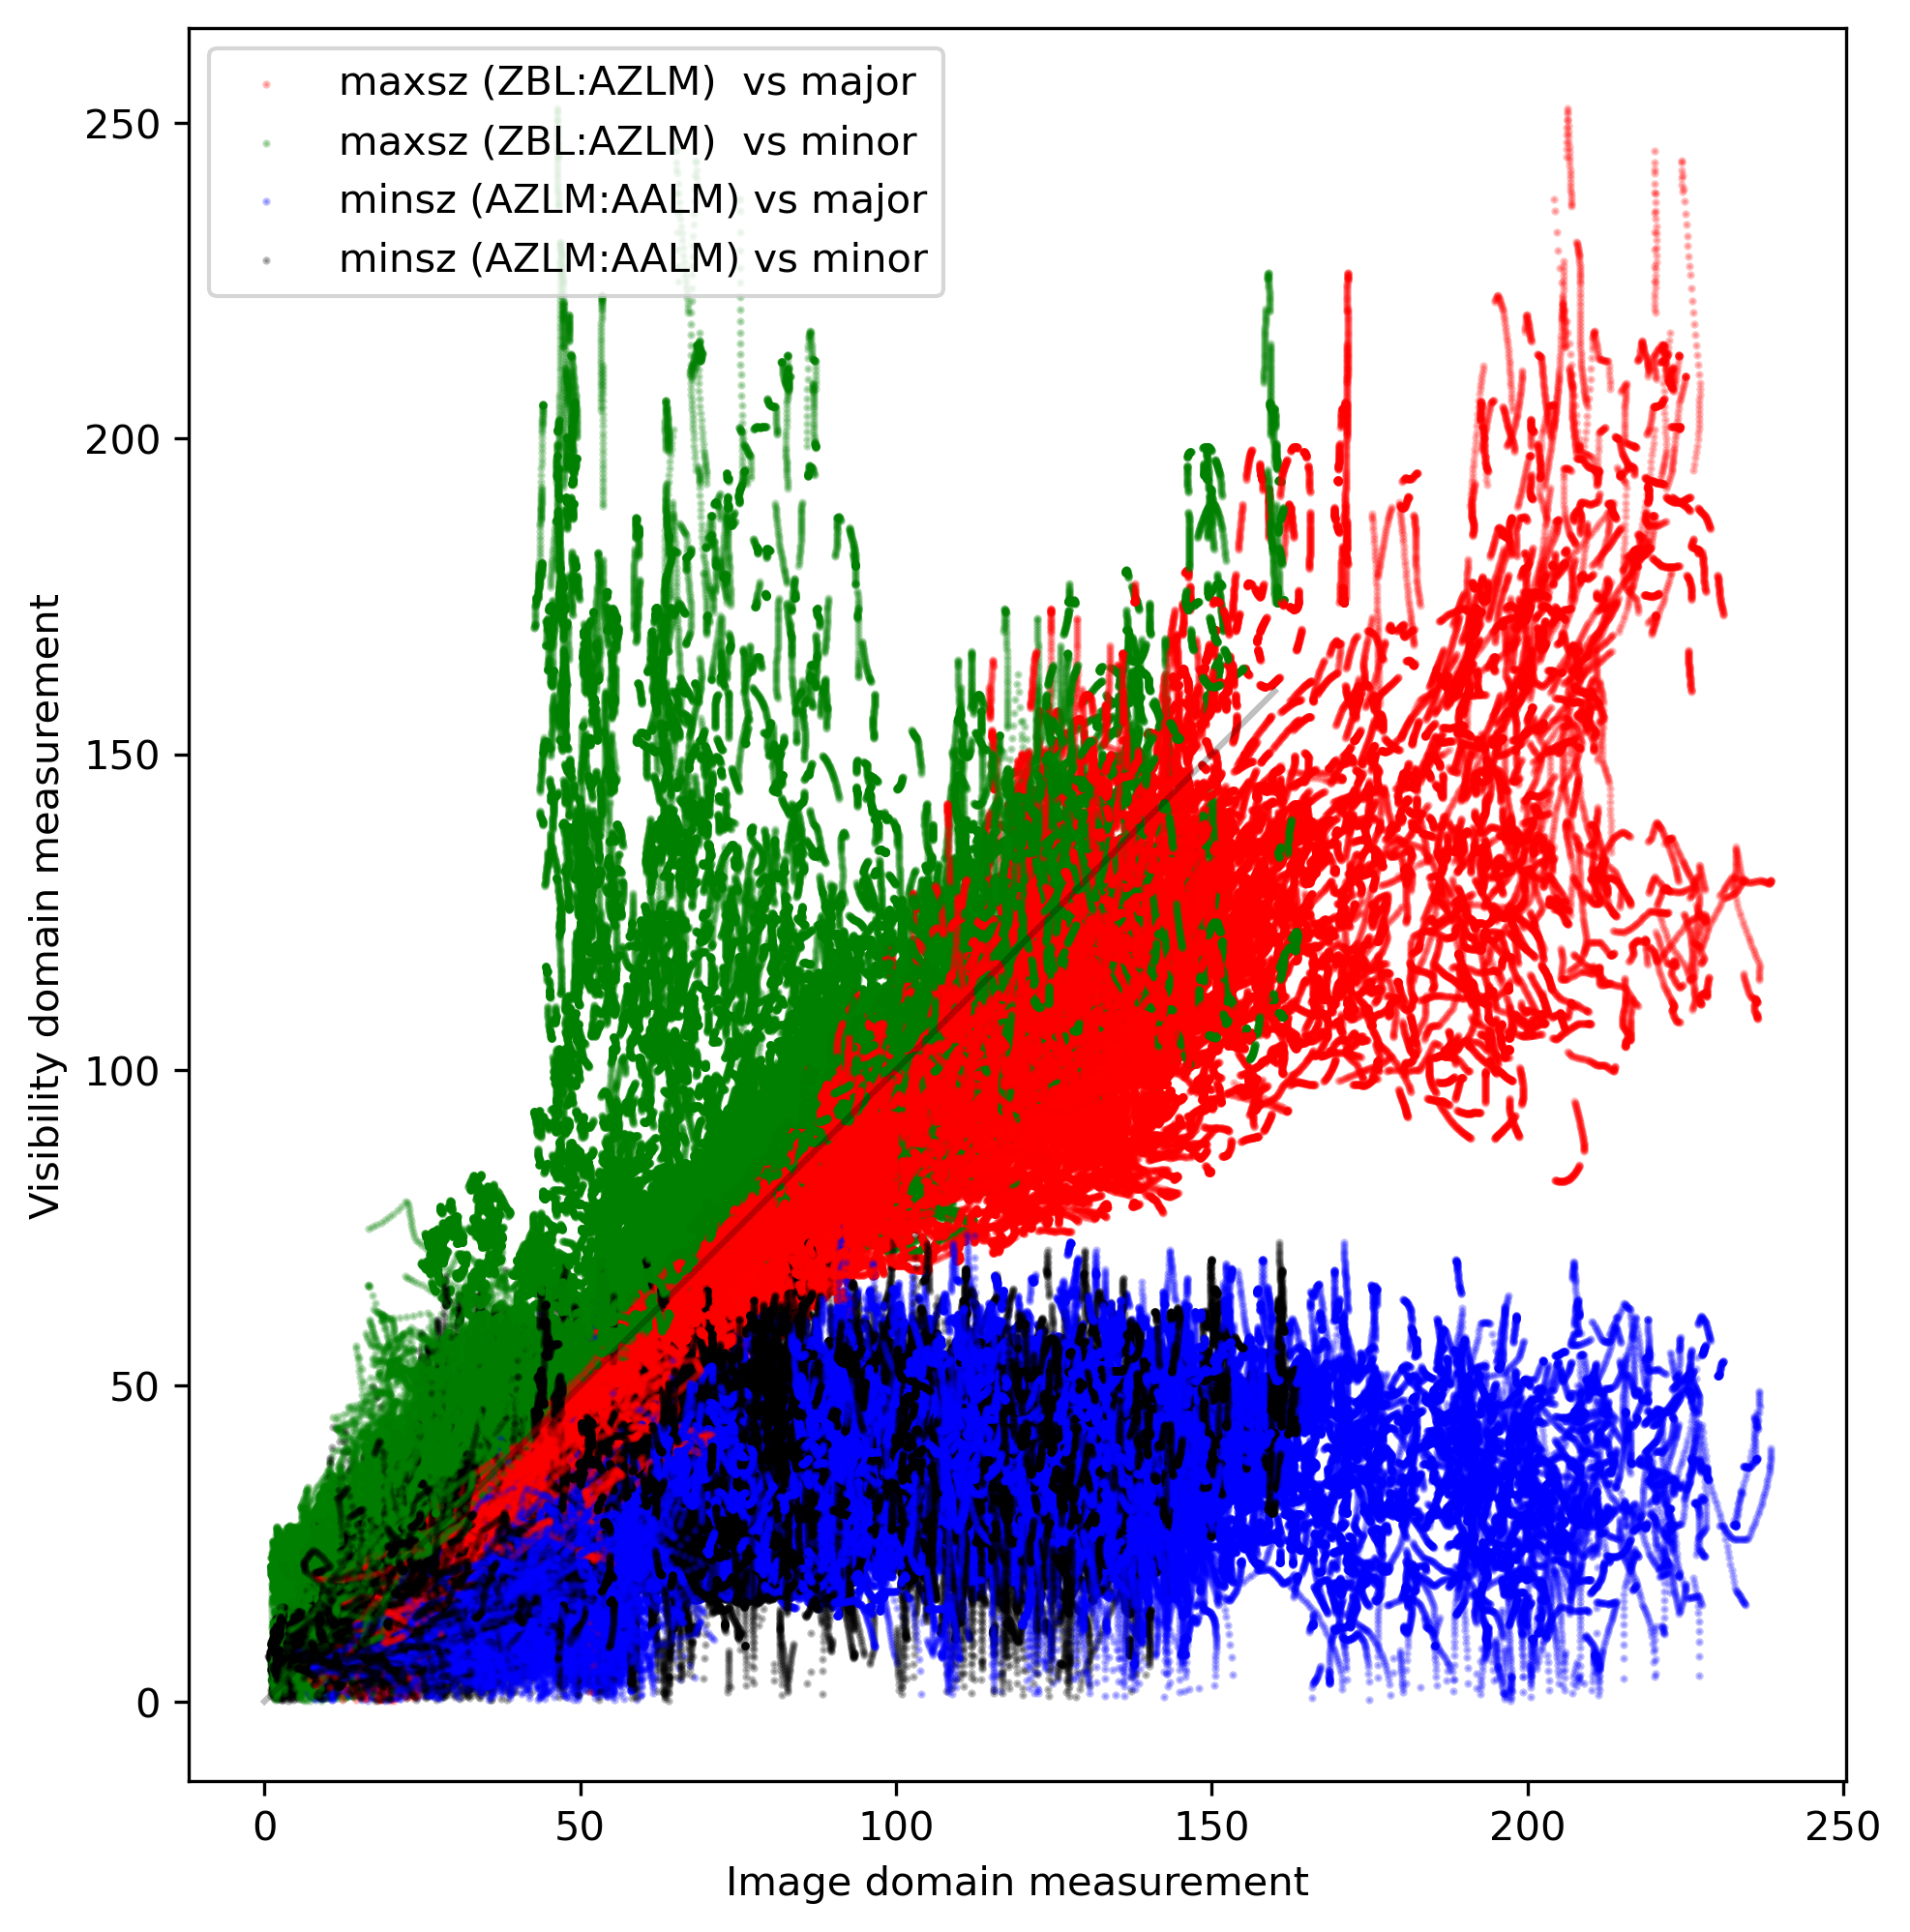

In [32]:
plt.figure(figsize=(8, 8), dpi=300)

for i, p in tqdm(enumerate(pf.path[:1000])):
    major, minor, maxsz, minsz = compare(p)
    
    if i == 0:
        plt.scatter(major, maxsz, s=1, color='r', alpha=1/4, label='maxsz (ZBL:AZLM)  vs major')
        plt.scatter(minor, maxsz, s=1, color='g', alpha=1/4, label='maxsz (ZBL:AZLM)  vs minor')
        plt.scatter(major, minsz, s=1, color='b', alpha=1/4, label='minsz (AZLM:AALM) vs major')
        plt.scatter(minor, minsz, s=1, color='k', alpha=1/4, label='minsz (AZLM:AALM) vs minor')
    else:
        plt.scatter(major, maxsz, s=1, color='r', alpha=1/4)
        plt.scatter(minor, maxsz, s=1, color='g', alpha=1/4)
        plt.scatter(major, minsz, s=1, color='b', alpha=1/4)
        plt.scatter(minor, minsz, s=1, color='k', alpha=1/4)

plt.plot([0,160], [0,160], color='k', alpha=1/4)
plt.legend(loc='upper left')

plt.gca().set_aspect('equal')
plt.xlabel('Image domain measurement')
plt.ylabel('Visibility domain measurement')

plt.savefig('output/plot/vis_vs_img.png')